#Importing Essential Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F

#Loading Data

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
image_path = '/content/drive/MyDrive/DL/Datasets/train'

image_data = []
image_masks = []

#Loading images
print("Loading Training Images...")

filenames = [os.path.join(image_path, img) for img in os.listdir(image_path)]
filenames.sort()
for img in filenames:
  image_arr = cv2.imread(img)  #One image of dim (W, H, 3)

  #Resizing
  new_image = cv2.resize(image_arr, (240,240))   
  new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
  image_data.append(new_image)
  
images = np.array(image_data)


#Loading Masks
image_mask_path = '/content/drive/MyDrive/DL/Datasets/train_masks'
print("Loading Training Masks...")
filenames = [os.path.join(image_mask_path, img) for img in os.listdir(image_mask_path)]
filenames.sort()

for img in filenames:
  image_arr = imageio.imread(img)  #One image of dim (W, H, 3)
  
  #Resizing
  new_image = cv2.resize(image_arr, (240,240))  
  image_masks.append(new_image)
    
  
images = np.array(image_data)
masks = np.array(image_masks)

print("Training images shape: " ,images.shape)     
print("Training Masks shape: ",masks.shape)      #Labels are grayscale Images

Loading Training Images...
Loading Training Masks...
Training images shape:  (5088, 240, 240, 3)
Training Masks shape:  (5088, 240, 240)


In [ ]:
#Loading takes time thus saving the numpy array to load faster in the futrue
file_path_save = 'images.npy'
np.save(file_path_save, images)

file_path_save = 'masks.npy'
np.save(file_path_save, masks)

Load images from here in order to save time. The saved numpy array can be loaded easily and it's very fast

In [ ]:
images = np.load('images.npy')
masks = np.load('masks.npy')

print("Shape of loaded images: ",images.shape)
print("Shape of loaded masks: ",masks.shape)


Shape of loaded images:  (5088, 240, 240, 3)
Shape of loaded masks:  (5088, 240, 240)


visualizing some images

Image


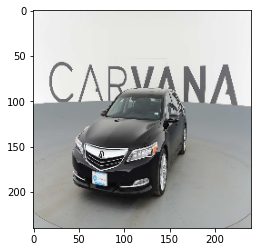

It's Mask


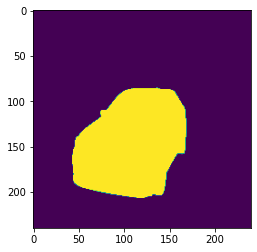

In [ ]:
plt.figure(1)
print("Image")
plt.imshow(images[1])
plt.show()
plt.figure(2)
print("It's Mask")
plt.imshow(masks[1])
plt.show()

Checking if GPU is available

In [ ]:
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'

cuda GPU is available


Transfering the images to GPU

In [ ]:
images = torch.tensor(images, device = DEVICE)
masks = torch.tensor(masks, device = DEVICE)


In [ ]:
#Normalizing the images according to stats given in pytorch website
#images = F.normalize(images, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
images = (images.float())/255
images[:,:,:,0] =(images[:,:,:,0] - 0.485) /0.229
images[:,:,:,1] =(images[:,:,:,1] - 0.456) /0.224
images[:,:,:,2] =(images[:,:,:,2] - 0.406) /0.225

#Normalize the images

In [ ]:
#changing image dimension to that which is accepted by the the model
images = images.permute(0,3,1,2)

#Pretrained Image Segmentation models from pytorch

In [ ]:
from torchvision.models.segmentation import fcn_resnet50
model = fcn_resnet50(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

The above model is trained on 21 classes. These classes are: background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor

In [ ]:
model = model.to(device = DEVICE)

In [ ]:
output = model(images[1].reshape(1,images.shape[1],images.shape[2], images.shape[3])) ['out']

torch.Size([1, 21, 240, 240])


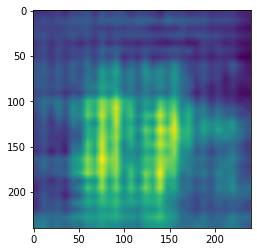

In [ ]:
print(output.shape)     #The model is trained on 21 classes car=7
plt.figure(3)
plt.imshow((output.reshape(21,240,240)[7]).detach().cpu())
plt.show()

In [ ]:
a = (output.reshape(21,240,240)).detach().cpu()
b = torch.argmax(a, dim=0)     #dtype is int
print(b.dtype)
#plt.imshow(a)

torch.int64


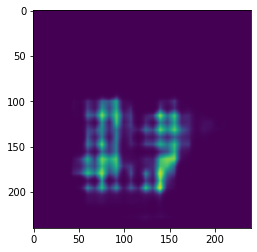

tensor([[2.5022e-07, 2.5022e-07, 2.5022e-07,  ..., 2.7691e-06, 2.7691e-06,
         2.7691e-06],
        [2.5022e-07, 2.5022e-07, 2.5022e-07,  ..., 2.7691e-06, 2.7691e-06,
         2.7691e-06],
        [2.5022e-07, 2.5022e-07, 2.5022e-07,  ..., 2.7691e-06, 2.7691e-06,
         2.7691e-06],
        ...,
        [6.0859e-07, 6.0859e-07, 6.0859e-07,  ..., 3.0145e-06, 3.0145e-06,
         3.0145e-06],
        [6.0859e-07, 6.0859e-07, 6.0859e-07,  ..., 3.0145e-06, 3.0145e-06,
         3.0145e-06],
        [6.0859e-07, 6.0859e-07, 6.0859e-07,  ..., 3.0145e-06, 3.0145e-06,
         3.0145e-06]])


In [ ]:
normalized_masks = torch.nn.functional.softmax(a, dim=0)
plt.imshow((normalized_masks[7]).cpu().numpy(), vmin=0.0, vmax=1.0)      #vmin=0.0, vmax=1.0)         #cmap='gray'
plt.show()
print(normalized_masks[3])

It Doesn't perform that good in carvana dataset let's try one image of the coco dataset on which it is trained

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2022-05-07 22:37:21--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.30.156
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.30.156|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  16.4MB/s    in 49s     

2022-05-07 22:38:10 (15.9 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
!unzip val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [ ]:
image_arr = cv2.imread('000000258911.jpg')  #One image of dim (W, H, 3)
new_image = cv2.resize(image_arr, (240,240))

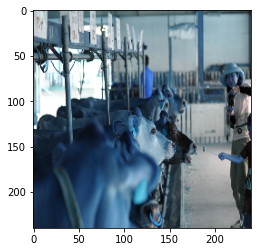

In [ ]:
image_coco = np.array(new_image)
plt.imshow(image_coco)
plt.show()                                 #It's blueish because of BGR format

In [ ]:
image_coco = cv2.cvtColor(image_coco, cv2.COLOR_BGR2RGB)

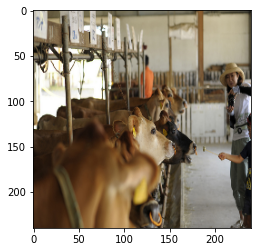

In [ ]:
plt.imshow(image_coco)
plt.show()

In [ ]:
image_coco = torch.tensor(image_coco, device = DEVICE)
image_coco = (image_coco.float())/255

image_coco[:,:,0] =(image_coco[:,:,0] - 0.485) /0.229
image_coco[:,:,1] =(image_coco[:,:,1] - 0.456) /0.224
image_coco[:,:,2] =(image_coco[:,:,2] - 0.406) /0.225

In [ ]:
image_coco = image_coco.permute(2,0,1)

In [ ]:
output_coco = model(image_coco.reshape(1,image_coco.shape[0],image_coco.shape[1], image_coco.shape[2])) ['out']
output_coco = torch.nn.functional.softmax(output_coco, dim=1)

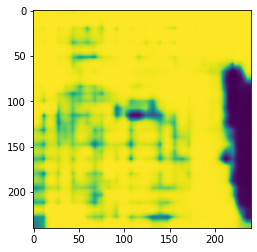

In [ ]:
plt.imshow((output_coco.reshape(21,240,240)[0]).detach().cpu())    #cow = 10, 0 for background
plt.show()